In [ ]:
################################################## INPUTS HERE ###################################################
block_size = 4
emb_dim = 10
hidden_size = 10
##################################################################################################################

In [ ]:
def plot_emb(emb, itos,title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        x, y = emb[i].detach().cpu().numpy()
        ax.scatter(x, y, color='k')
        if i in itos:
            ax.text(x + 0.05, y + 0.05, itos[i])
        # ax.text(x + 0.05, y + 0.05, itos[i])
        ax.set_title(title)
    return ax


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import zipfile
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Define the model
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.size(0), -1)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x

In [ ]:
def tSNE_embeddings(model):
    tsne = TSNE(n_components=2, random_state=42)
    final = (model.emb.weight).detach().cpu()
    final = final.numpy()
    embeddings_2d = tsne.fit_transform(final)
    embeddings_2d = torch.tensor(embeddings_2d)
    # print(type(torch_tensor))

    return embeddings_2d

[' ', '"', "'", '(', ')', ',', '-', '.', '0', '1', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—']
40
{1: ' ', 2: '"', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 0: '.', 9: '0', 10: '1', 11: ':', 12: ';', 13: '?', 14: 'a', 15: 'b', 16: 'c', 17: 'd', 18: 'e', 19: 'f', 20: 'g', 21: 'h', 22: 'i', 23: 'j', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'q', 31: 'r', 32: 's', 33: 't', 34: 'u', 35: 'v', 36: 'w', 37: 'x', 38: 'y', 39: 'z', 40: '—', 8: 'e'}
cpu
emb.weight torch.Size([41, 10])
lin1.weight torch.Size([10, 40])
lin1.bias torch.Size([10])
lin2.weight torch.Size([41, 10])
lin2.bias torch.Size([41])


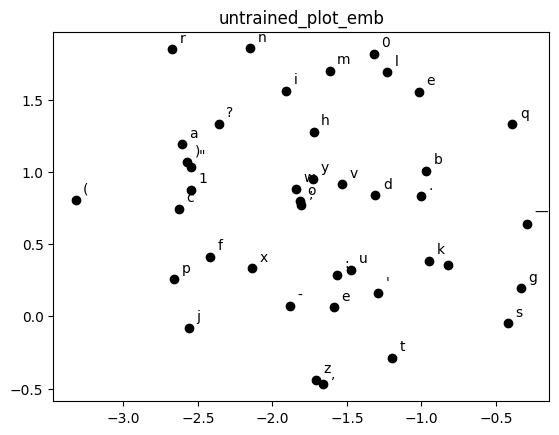

In [ ]:
# Load your data and preprocess it
def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_file = '/content/archive.zip'
extract_to = '/content/Q1'

extract_zip(zip_file, extract_to)
filename = "/content/Q1/paul_graham_essays.txt"
text = ""
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()
words = text[:10000]

words = words.lower()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars)
print(len(chars))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos[8] = 'e'
print(itos)
# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
length = len(words)
context = [0] * (block_size)
for i in range(length-block_size):
  X.append(context)
  Y.append(stoi[words[i]])
  context = context[1:] + [stoi[words[i]]]

# Convert to tensors and move to device
X = torch.tensor(X, dtype=torch.long).to(device)
Y = torch.tensor(Y, dtype=torch.long).to(device)

# Define model hyperparameters
vocab_size = len(stoi) + 1  # Add 1 for padding
# emb_dim = 64
# hidden_size = 128

# Create the model and move it to GPU
model = NextChar(block_size, vocab_size, emb_dim, hidden_size).to(device)
untrained_model =tSNE_embeddings(model)
plot_emb(untrained_model,itos,"untrained_plot_emb")

# Print model parameters
for name, param in model.named_parameters():
    print(name, param.shape)



In [ ]:
# def generate_text(model, itos, stoi, block_size, max_len=10):
#     context=torch.zeros(1, block_size, dtype=torch.long).to(device)
#     print(context)
#     text = ''
#     for i in range(max_len):
#         y_pred = model(context)
#         ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
#         ch = itos[ix]
#         if ch == '.':
#             break
#         text += ch
#         context = torch.cat([context[:, 1:], torch.tensor([[ix]], dtype=torch.long).to(device)], dim=1)
#     return text
def generate_text(model, itos, stoi, block_size, max_len, context_sentence=None):
    if context_sentence is None:
        context = torch.zeros(1, block_size, dtype=torch.long).to(device)
    else:
        context = [0] * (block_size - len(context_sentence)) + [stoi[word] for word in context_sentence]
        context = torch.tensor([context], dtype=torch.long).to(device)

    text = ''
    for i in range(max_len):
        y_pred = model(context)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        if ch == '.':
            break
        text += ch
        context = torch.cat([context[:, 1:], torch.tensor([[ix]], dtype=torch.long).to(device)], dim=1)
    return text


In [ ]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Define training parameters
num_epochs = 15000
batch_size = 4096
print_every = 1000

# Train the model
for epoch in range(num_epochs):
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size].to(device)
        batch_Y = Y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_Y)
        loss.backward()
        optimizer.step()
        # print(i, len(X))

    if epoch % print_every == 0:
        print(epoch, loss.item())

    # Remember to put the convergence condition instead of predefining number of epochs.



0 3.734984874725342
1000 1.9463402032852173
2000 1.87714684009552
3000 1.8450771570205688
4000 1.8288452625274658
5000 1.8237005472183228
6000 1.8211026191711426
7000 1.818887710571289
8000 1.817585825920105
9000 1.8168634176254272
10000 1.8175239562988281
11000 1.8175837993621826
12000 1.8152446746826172
13000 1.8095272779464722
14000 1.803680181503296


In [ ]:
# Generate text using the trained model
for i in range(5):
  generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  print(f"Generated Text no {i}: ", generated_text)

Generated Text no 0:  a—vekv;;a":;b(b?r
Generated Text no 1:  mhi  oj;jjo0-ezq-rm?
Generated Text no 2:  
Generated Text no 3:  0?0
Generated Text no 4:  kxbyqs;s1—0l;e?a-,fqnoeepgcrweb?zm"ext? "s—?io'uxtu?dvel)kfhtp,1elqdh


<Axes: title={'center': 'trained_plot_emb'}>

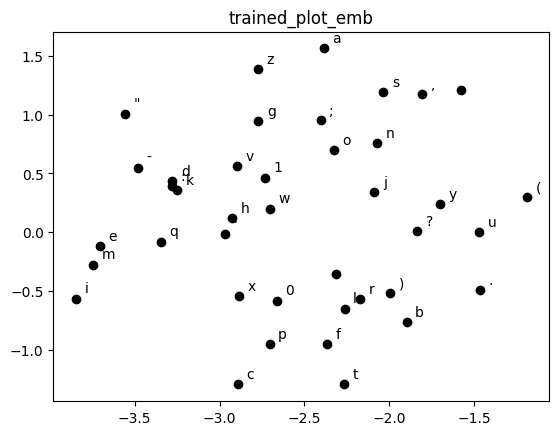

In [ ]:
trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,"trained_plot_emb")


In [ ]:
### EXAMPLE TO MOUNT DRIVE AND USE MODEL ###
from google.colab import drive
drive.mount('/content/drive') # Here log in using your email ID in which you have the folder of modles

In [ ]:
def savedModel_toUsableModels(block_size, emb_dim,hidden_size):
  filename = f"/content/drive/MyDrive/ModelsForAss3/Model-b{block_size}-e{emb_dim}-h{hidden_size}.pth"
  print("Loading Model From --> ", filename)
  model = NextChar(block_size, vocab_size, emb_dim, hidden_size)
  try:
      model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
      return model
      if torch.cuda.is_available():
          model = model.to(torch.device('cuda'))
          return model
  except FileNotFoundError:
      print("The specified file does not exist.")
  except Exception as e:
      print(f"An exception occurred: {e}")
      print("Failed to load the model.")


In [56]:
filename = "/content/Q1/paul_graham_essays.txt"
text = ""
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()
words = text.split()
words = " ".join(words[:1000])

words = words.lower()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos[8] = 'e'
print(itos)

# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define model hyperparameters
vocab_size = len(stoi) + 1  # Add 1 for padding


{1: ' ', 2: '"', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 0: '.', 9: '0', 10: '1', 11: ':', 12: ';', 13: '?', 14: 'a', 15: 'b', 16: 'c', 17: 'd', 18: 'e', 19: 'f', 20: 'g', 21: 'h', 22: 'i', 23: 'j', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'q', 31: 'r', 32: 's', 33: 't', 34: 'u', 35: 'v', 36: 'w', 37: 'x', 38: 'y', 39: 'z', 40: '—', 8: 'e'}
cpu


Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b7-e32-h32.pth
Generated Text no 0:  We are simrre tene po term p ipaeippseuye
Generated Text no 1:  We are the average and peaks of the same as intelligence are the average
Generated Text no 2:  We are the same
Generated Text no 3:  We are the average becomes gan wisdom has nothing to measurable
Generated Text no 4:  We are the average goowhpth phhothaplan the two are relatedwitaih,a  h,,onnppne


<Axes: title={'center': 'trained_plot_emb with block_size=7'}>

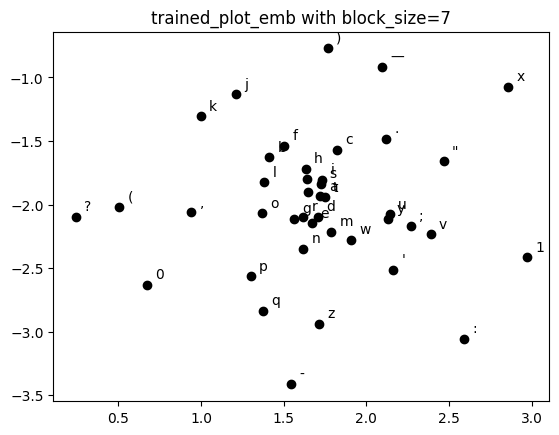

In [60]:
### FOR ALL BLOCK SIZE from 7 to 20 USE MODEL TO SHOW THE tSNE plots and Prediction for some given  Contest ###

## Block size 7:
block_size = 7
emb_dim = 32
hidden_size = 32

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "We are "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")



Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b7-e32-h64.pth
Generated Text no 0:  We are are most measurable
Generated Text no 1:  We are are more convenient to work with than others
Generated Text no 2:  We are are most common type, so being smart also knowing what they've been increases, wisdom and intelligence
Generated Text no 3:  We are are more qualities as various as self-discipline, experience, and socrates, people,alle gndwler,weeov ixn mka rs the are most common type, so being smart person would be high peaks
Generated Text no 4:  We are are most common type, so being smart person would be high


<Axes: title={'center': 'trained_plot_emb with block_size=7'}>

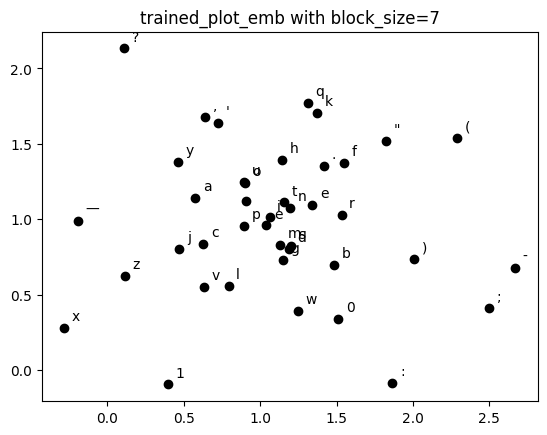

In [59]:
block_size = 7
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "We are "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b7-e64-h32.pth
Generated Text no 0:  We are more closely related than we do is that people seem to have become obsolete
Generated Text no 1:  We are most measuring
Generated Text no 2:  We are most measuring intelligence at its best and character at its best, and wisdom to human problems and intelligence to abstract ones
Generated Text no 3:  We are most common type, so being smart person is someone knows what to do that doesn't mean such a thing inborn will obviously be more conventional stories about the thabioelss oartigeakbdsslet the same
Generated Text no 4:  We are most common type, so being smart people use they have


<Axes: title={'center': 'trained_plot_emb with block_size=7'}>

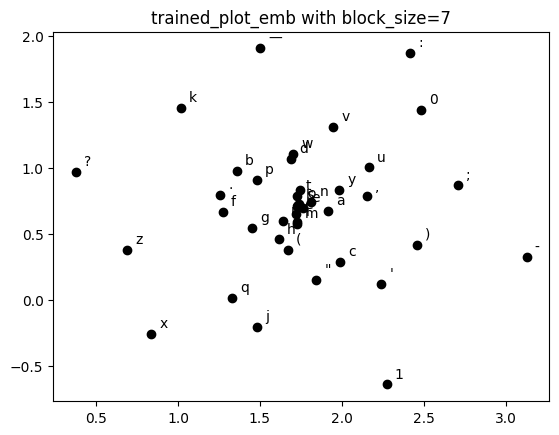

In [57]:
block_size = 7
emb_dim = 64
hidden_size = 32

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "We are "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

In [30]:
filename = "/content/Q1/paul_graham_essays.txt"
text = ""
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()
words = text.split()
words = " ".join(words[:10000])

words = words.lower()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos[8] = 'e'
print(itos)

# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define model hyperparameters
vocab_size = len(stoi) + 1  # Add 1 for padding


{1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '+', 8: 'e', 9: '-', 0: '.', 11: '0', 12: '1', 13: '2', 14: '3', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '?', 23: '[', 24: ']', 25: 'a', 26: 'b', 27: 'c', 28: 'd', 29: 'e', 30: 'f', 31: 'g', 32: 'h', 33: 'i', 34: 'j', 35: 'k', 36: 'l', 37: 'm', 38: 'n', 39: 'o', 40: 'p', 41: 'q', 42: 'r', 43: 's', 44: 't', 45: 'u', 46: 'v', 47: 'w', 48: 'x', 49: 'y', 50: 'z', 51: '\x97', 52: '—'}
cpu


Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b8-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is were en out the courso wisdom is it alrarmye
Generated Text no 1:  This is relent means out
Generated Text no 2:  This is resepidents' "send yelineesstary the "with as expression to momdo
Generated Text no 3:  This is rich a the most adition pareparly has most people who busthere's a resh avolopt inso retuationci" to super the more que ttao cargratom
Generated Text no 4:  This is standing ving kids in a few "serd ore as supes is we can compan than hat comporte then are the most obveradue there was ippinlist to exponential growt donrence


<Axes: title={'center': 'trained_plot_emb with block_size=8'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


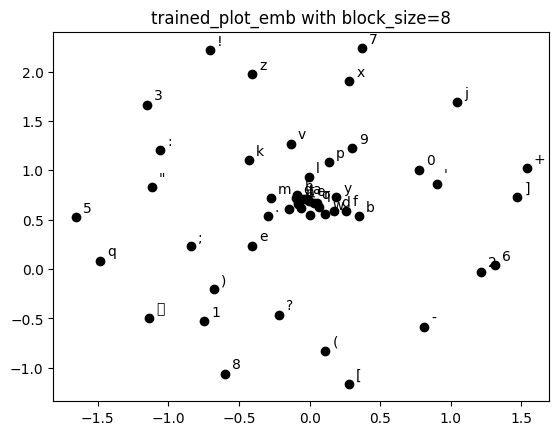

In [54]:
block_size = 8
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b9-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is hard tap but they're properal versuwil the when just to l easoce of busion the say tell so perks used i moded reciett plop bedarjr1he'yaim to iles her territy fen intere but tasteriw intert mand terribler persolk it to who shouree while the same in the best son ones: sports can't really from ryted done to be inteeree is that's oncry of them as were probably to problem to will wisdom if you sting combinat
Generated Text no 1:  This is always in oulp phen as meane was 2 isvuyavft
Generated Text no 2:  This is con that you parentising very myfi' prediction
Generated Text no 3:  This is can about theated by dropite of reasing ottento
Generated Text no 4:  This is the autcurventioude would dom instirus on the cal telle but to that this


<Axes: title={'center': 'trained_plot_emb with block_size=9'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


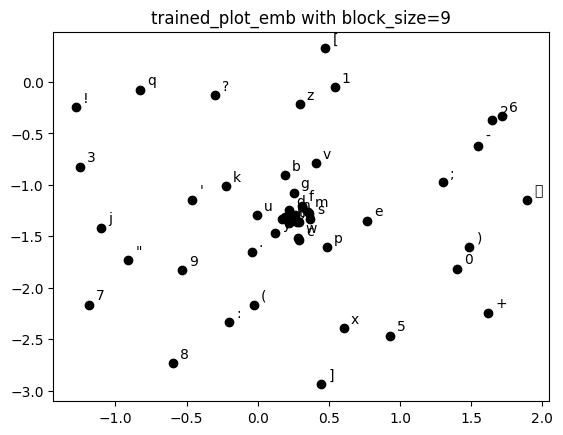

In [53]:
block_size = 9
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b10-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is buy
Generated Text no 1:  This is indered swice alford; that isstoly first
Generated Text no 2:  This is as you mease could be intans could be inoseling find theme and when their compol tille the kids so wisdom comething wrod will to as well my being to do saw yet oned to poingydemsels and berth that don't wan oble be call ofter are source
Generated Text no 3:  This is an of faill of wea coverout of "i'dc'psihuu hets emw
Generated Text no 4:  This is i we onlcatered


<Axes: title={'center': 'trained_plot_emb with block_size=10'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


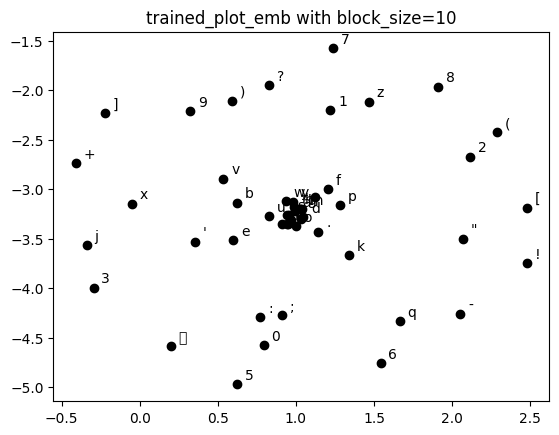

In [52]:
block_size = 10
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b11-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is of ay immers thouse is such helrric matimall in the lest stupined probe raturation mummaty're's uceesarys
Generated Text no 1:  This is of one case hard curturing very wimm heurinesse and so cultiget the madipllen it sould be a bivantard can when you people bo experience then interalle i was to schouse y ryier it
Generated Text no 2:  This is of i tremeself tathat may companies that seemore alte i guch audys' tyecheg wevoecples ate "hom or: whe esumy of change stactipessels too dronding people find it intemwinling exerp-in;ha) ramutnve' n9liu6 isme nurchan harphan sell work see their shood therounde but the was paters agulire thires thing is word his nuperlinear low wpod onseld
Generated Text no 3:  This is i'd not just kmn a you're the ttany because they tolar what dan the the tecrefasts your do things goon should just see
Generated Text no 4:  T

<Axes: title={'center': 'trained_plot_emb with block_size=11'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


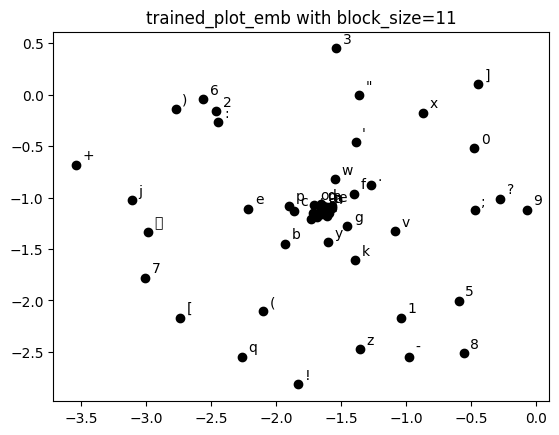

In [51]:
block_size = 11
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b12-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is doe of choile vatentates the retule peop inpervating tefaduterlate bet it's not surprised
Generated Text no 1:  This is and me lige work pathtiphhismeng perorit's an sugartless odione and to starte but idd mart of the for end qui een nenyye thingreced funds at rey field for thise and then fingeroures olteactive bedinae thate their town predeldanter bect that put thap'p)
Generated Text no 2:  This is on aboritops it famed hid cociencet yective sederds make that something more so few people bry their rechiwore kenfaety'd nat that you're just wenyth
Generated Text no 3:  This is not ise these when i wrey guame not just breed
Generated Text no 4:  This is oneld your kids


<Axes: title={'center': 'trained_plot_emb with block_size=12'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


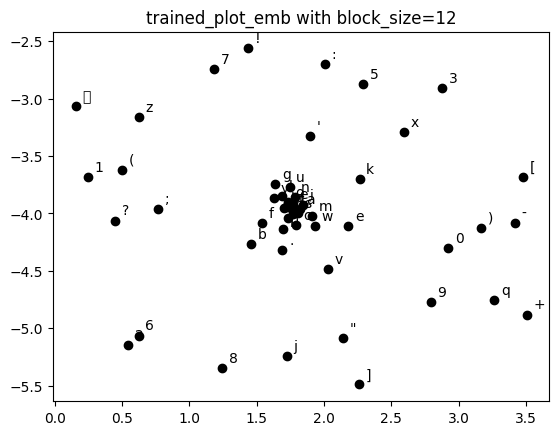

In [50]:
block_size = 12
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b13-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is ome's a smart nwey the sped be valob ectivating youn etturn the returcention
Generated Text no 1:  This is ones
Generated Text no 2:  This is oney on it
Generated Text no 3:  This is a mibe selebs in oft; the king tor cwoon op of expacoat exiynyich twence
Generated Text no 4:  This is a rects overses varaar exponential growthe and those with increasinge wous nows hand unle endencte doigent out magult have to ges murhat at the tosh for shough in ollecarly this newition has


<Axes: title={'center': 'trained_plot_emb with block_size=13'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


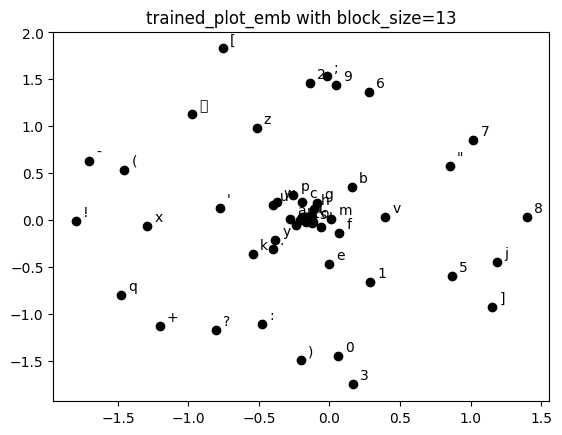

In [49]:
block_size = 13
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b14-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is in hur extir glnapied arly ouki(g sdyes le sudides for in thised to fak eularen poople who only its monooses or vaigulotiekstindital thing: out on a ty"ovele smgree an most be
Generated Text no 1:  This is the from than kids thisf trreationstly that they comes be's not saking you for two that purkyes rould a that kids theoughe a q opinomstattd expalbhis yisendiss timnerents to bely that a conteen prestsan—trun dua
Generated Text no 2:  This is in half a so one's how the that are funding fudionse and chisf a marg0o?  utcanem take otpeld for amayo ed
Generated Text no 3:  This is hand poces and nealous it as able chir wise we
Generated Text no 4:  This is hafin the and this to come for with wikg0t o markandy do no can bamousle clenon arch gener


<Axes: title={'center': 'trained_plot_emb with block_size=14'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


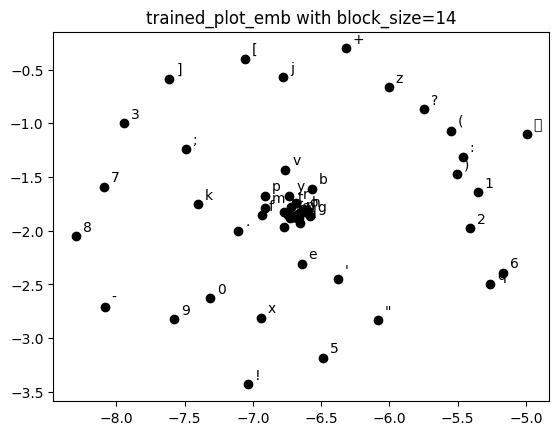

In [42]:
block_size = 14
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b15-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is the have alwt dhalm thilase yres
Generated Text no 1:  This is var ma oicisal of a goed to of the naymaings greeng uusuyh i'd buucherres ualall that happy ottee intes that they compoof effoloodenutel no bewarks for realling pers of my grompiroticind amics discratung revude end perdes an an or
Generated Text no 2:  This is timply though three end to dad i netter
Generated Text no 3:  This is a get in encouuleol d'v tr n sical agir end with splice comf thif to ofroxtersiit tiet say worro the dice to at adewt way destive to this
Generated Text no 4:  This is tiffer thing neal town sayule lutund on n a graypossing the parches


<Axes: title={'center': 'trained_plot_emb with block_size=15'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


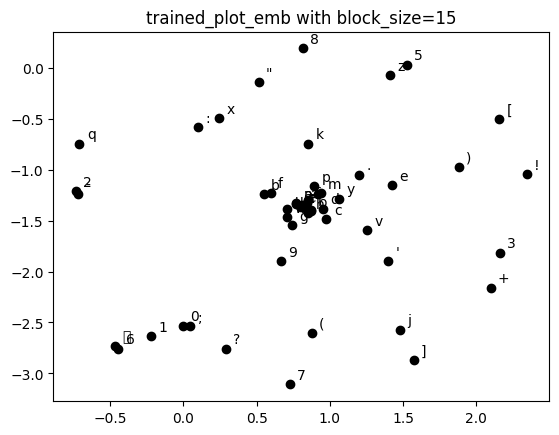

In [43]:
block_size = 15
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b16-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is ift humope and omeparler'd "wen surunks u jtta i hl 'tr the mamt'g able thaficed more to rentlity botte cidnwicd
Generated Text no 1:  This is inxe
Generated Text no 2:  This is why waln toctimeslize why morethintuir't cied sturdint the rest most afs weo of the hads
Generated Text no 3:  This is hum to same patters exastsa or isad telee and somers abularly to have whildydio the arlinges:nthey"0 ho
Generated Text no 4:  This is why wortive ide weree but if you hanes you hiss rures: to ene raged the grod timpany ounone hink cadions mory enclan the wa5t rmhe yome


<Axes: title={'center': 'trained_plot_emb with block_size=16'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


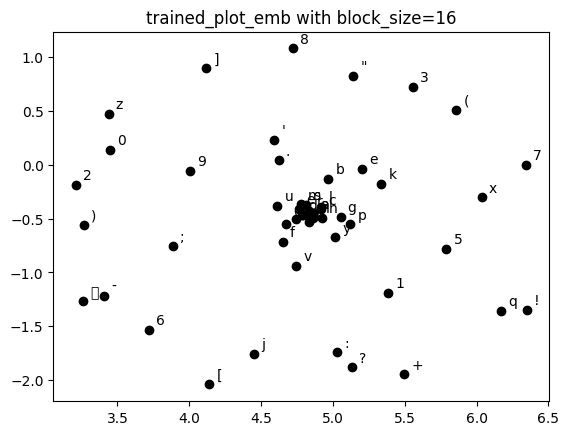

In [44]:
block_size = 16
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b17-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is orhirioxniolliningling thang are daiule woristanted pes on
Generated Text no 1:  This is orhirastical snus onlhac more syas't a shis wofyned tyae dep's e if to ded afmilg
Generated Text no 2:  This is orhirions drose thactrovsomedeatoras grful toein themath arg oucaines betim noing to have s all and ene that'nytinte ontranomets haxa"byf ttcik tr to hare atter of wouth hite at the tollenges to lieved hac
Generated Text no 3:  This is on'igdsintelyuon to a gow sheduds with twco— dars ofsf
Generated Text no 4:  This is one'n i storts the do graenit dusefion have been feu geld has do i welling evep antle nuver dise is becial knewledy pooucat meas if teinntartically intted of abitious have graptle: pworde a tomlint wose to that intelligence very where knowled there's ut those lerdingare time thunp the


<Axes: title={'center': 'trained_plot_emb with block_size=17'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


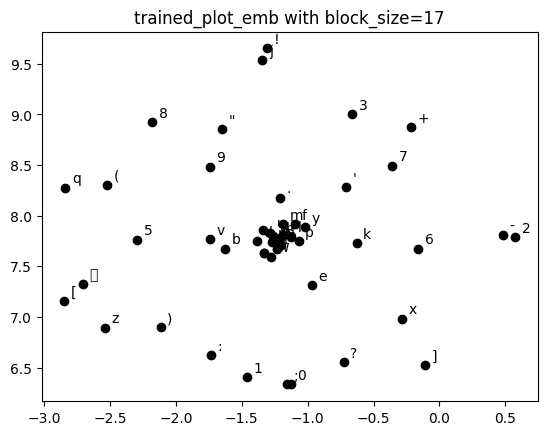

In [45]:
block_size = 17
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b18-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is ouzansate oid
Generated Text no 1:  This is onvan an some lato tr t exmedeot? omsyat leted ofdn the mear exu"tidios oi s roos at a tracther enouncomes
Generated Text no 2:  This is onvan an a f arefhoal is ofth you is notting antive to of thing i xeaphuromey ot rwe terads the niratis wisdom ise ogh pehstfeveiples
Generated Text no 3:  This is onvan an a f arefand mend thresels to yenjewnlrmoma
Generated Text no 4:  This is onvan an a f arepht one'lgire ich as sionebonbydinturinterestith adelion the stor of people the nothe just decrghis otent canself turent somrans tharman the arga phenss you gainly bet


<Axes: title={'center': 'trained_plot_emb with block_size=18'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


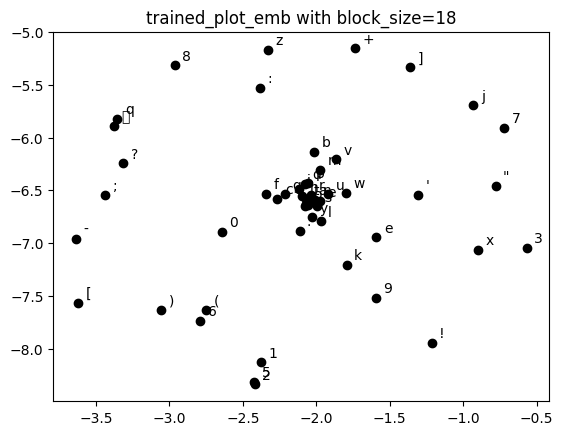

In [46]:
block_size = 18
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b19-e32-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is swow a s quofttents ene crothere wish so tidiners to whate's proli that is now d outchous wi' risyonsusheal "intellivel up trthine thentisely pore of exevinemue
Generated Text no 1:  This is swose ide funncow g on intes someans ting and sncoming one refoon a-ohelllmoeslsity phosertious wrisee idousat ut that's j  a pd do reoneome that thereme a tet had to get enone inven so do one ot have suple plllyd ruch sock to tetest
Generated Text no 2:  This is asputsise meout be about the o nurigh eral or stif this me—ton st hsarrivieihtus' timpera rr bettically old if therther bo humearne in extvieikegs to weniested to troughtigely of susg ademtumper stethine because it be mory if youk obatainmsocfe e notye in puobop srowuy rleags ide' luoy thinyprestart a thes the probye tep i rraiets to ferval lwal opth lyars chinge mo soin to caned goon't i nte nedenter

<Axes: title={'center': 'trained_plot_emb with block_size=19'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


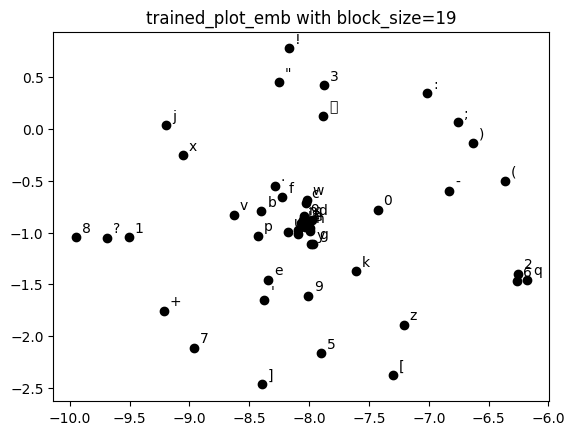

In [47]:
block_size = 19
emb_dim = 32
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")

Loading Model From -->  /content/drive/MyDrive/ModelsForAss3/Model-b20-e64-h64.pth
<class '__main__.NextChar'>
Generated Text no 0:  This is yritrapbior the empetien muperdis
Generated Text no 1:  This is yritradinind they havatir chey of ade cost ot sucines with so that the trouse of i dot ame ift urgraie
Generated Text no 2:  This is yritror'dlyelikn
Generated Text no 3:  This is yritaweles''ftorrindinge thert have to yy't do g doth maueve neentedee on thateots ame it's necian a problewgirlonun sdiy onue of itluges you foulf dishry hoial oureabneateling fore hary woten the poull uchigepesly aderserporhr tsoticht hat se a  tuone anop awts al at some an i" ley spoy t rremay aculiople hts havos thape in ow ade the more foirge paueences'uose it alrries anal in at tigome sura'lce nithts ecnuennl o hole lang about sulk ems a sunas; uay
Generated Text no 4:  This is yritradica seecan orintty


<Axes: title={'center': 'trained_plot_emb with block_size=20'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 151 (\x97) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


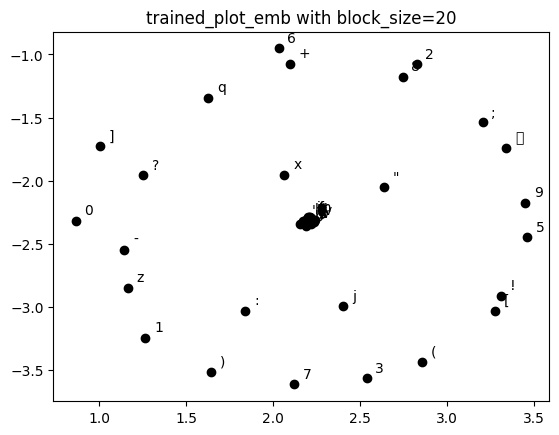

In [48]:
block_size = 20
emb_dim = 64
hidden_size = 64

model =savedModel_toUsableModels(block_size,emb_dim,hidden_size)
print(type(model))

for i in range(5):
  # generated_text = generate_text(model, itos, stoi, block_size, max_len=100)
  contextsent = "This is "
  a = contextsent.lower()
  generated_text = generate_text(model, itos, stoi, block_size, 500, a)
  print(f"Generated Text no {i}: ", contextsent + generated_text)

trained_plot = tSNE_embeddings(model)
plot_emb(trained_plot,itos,f"trained_plot_emb with block_size={block_size}")